# 15. 3. 4 여러 타임 스텝 앞을 예측하기 

타깃을 바꾸어 여러 타임 스텝 앞의 값을 예측할수있음 

(예를들어 1 스텝 앞이 아니라 10 스텝 앞의 값으로 타깃을 바꾸어 10스텝 앞을 예측)

**다음값 예측은?**

1. 이미 훈련된 모델을 사용하여 다음 값을 예측한다음 입력으로 추가 
  - 이 모델을 사용해 다시 다음 값을 예측하는 식

In [ ]:
series = generate_time_series(1, n_steps +10)
X_new, Y_new = series[:, :n_steps], sereis[:, n_steps:]
X = X_new

for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]# 다음 날 예측
  X = np.concatenate([X, y_pred_one], axis=1) # 예측한 값을 다시 학습 데이터셋과 결합

Y_pred = X[:, n_steps:]

미래의 타임 스텝은 오차가 누적될 수있어서 다음 스텝에 대한 예측은 보통 더 미래의 타임스텝에 대한 예측보다 정확함

이 방식은 약 0.029의 MSE를 얻음 

한번에 하나의 미래 스텝을 예측하기 위해 RNN을 사용하는것보다 나음 



2. RNN 을 훈련하여 한번에 10개 예측   
      - 시퀀스-투-벡터 모델을 사용하지만, 값 10개를 출력해야함 -> 타깃을 다음 10개의 값이 담긴 벡터로 바꿈 


In [ ]:
series = generate_time_serues(10000, n_steps + 10)
# Y_train, valid, test의 sequence_length가 10이 됨
X_train, Y_train = series[:7000, : n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN# 한개의 유닛이 아니라 10개의 유닛을 가진 출력층이 필요
])

In [ ]:
Y_pred = model.predict(X_new) # 한번에 다음값 10개를 매우 쉽게 예측할수있음 

MSE는 약 0.008

선형모델보다 좋음 

하지만 마지막 타임 스텝에서만 다음 값 10개를 예측하도록 모델을 훈련하는 대신 모든 타임 스텝에서 다음 값 10개를 예측하도록 모델을 훈련할 수 있음 

  -**시퀀스-투-시퀀스 RNN**

장점: 마지막 타임 스텝에서의 출력뿐 아니라 모든 타임 스텝에서 RNN출력에 대한 항이 손실에 포함 

- 더 많은 오차 그래디언트가 모델로 흐르며, 시간에 따라 흐를 필요가 없음
- 훈련을 안정적으로 만들고 훈련 속도를 높임


In [ ]:
Y = np.empty((10000, n_steps, 10)) # 각 타깃은 10D 벡터의 시퀀스
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000] 
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape # (7000, 50, 1)
Y_train.shape # (7000, 50, 10)


- 시퀀스-투-시퀀스 모델로 바꾸기 위해, 모든 순환 층에 return_sequences=True 로 지정

- 모든 타임 스텝에서 출력을 Dense 층에 적용 => TimeDistributed 층 사용

1.  이 층은 다른 층을 감싸 입력 시퀀스의 모든 타임 스텝에 이를 적용
2.  각 타임 스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꾸어 효과적으로 수행
3.  그 후 Dense층에 적용
마지막으로 출력 크기를 시퀀스로 되돌림
4.  여기서 Dense 층이 유닛을 10개 가지므로 출력 차원의 길이는 10

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),# TimeDistributed 적용을 위해 마지막 층에도 return_sequences=True 필수
    keras.layers.TimeDistributed(keras.layers.Dense(10)) 
])

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer=keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", metrics=[last_time_step_mse])

훈련하는동안 모든 출력이 필요하지만 예측과 평가에는 마지막 타임 스텝의 출력만 사용됨 

평가를 위해 마지막 타임 스텝의 출력에 대한 MSE만을 계산하는 사용자 정의 지표 사용


MSE 로 0.006 -> 이전보다 25% 향상

처음모델과 결합가능 

이 RNN을 사용해 다음값 10개를 예측하고 이 값을 입력 시계열에 연결한후 다시 다음값 10개를 예측 

- 긴 시계열이나 시퀀스에서 잘 작동하지 않음 

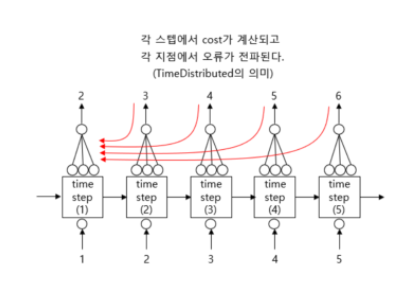

TimeDistributed를 통해 각 스텝 지점에서 발생하는 오류가 하위 스텝으로 전파됨

반대로 TimeDistributed를 사용하지 않으면 오류가 마지막 층에서 한 번 계산되고 이것이 첫 스텝까지 전파된다

각각 many-to-many, many-to-one RNN이라고 부름



